In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np
import streamlit as st
from joblib import load
from confluent_kafka import Consumer, KafkaError
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim


In [2]:
def merge_csv_files(directory):
    # List all CSV files in the directory
    csv_files = [file for file in os.listdir(directory) if file.endswith('.csv')]

    # Initialize an empty DataFrame to store the merged data
    merged_df = pd.DataFrame()
    count=1
    # Flag to indicate whether to include headers
    include_headers = True
    flag=0 if include_headers else None
    # Iterate over each CSV file and merge into the DataFrame
    for file in csv_files:
        file_path = os.path.join(directory, file)
        # Skip headers for all files except the first one
        df = pd.read_csv(file_path, header=flag)
        
        merged_df = pd.concat([merged_df, df], ignore_index=True)
        include_headers = False  # Headers only for the first file
        if count%5==0:
            print(count/len(csv_files))
        count+=1

    return merged_df

In [3]:

# def merge_csv_files(directory):
#     # List all CSV files in the directory
#     csv_files = [file for file in os.listdir(directory) if file.endswith('.csv')]

#     # Initialize an empty DataFrame to store the merged data
#     merged_df = pd.DataFrame()
#     count=1
#     # Flag to indicate whether to include headers
#     include_headers = True
#     flag=0 if include_headers else None
#     # Iterate over each CSV file and merge into the DataFrame
#     for file in csv_files:
#         file_path = os.path.join(directory, file)
#         # Skip headers for all files except the first one
#         df = pd.read_csv(file_path, header=flag)
#         df=df[df['area_code'].str.contains('VIC', na=False) | df['area_code'].isnull()]
#         merged_df = pd.concat([merged_df, df], ignore_index=True)
#         include_headers = False  # Headers only for the first file
#         if count%5==0:
#             print(count/len(csv_files))
#         count+=1

#     return merged_df

# # Specify the directory containing CSV files
# csv_directory = './weather/obs/'

# # Merge CSV files and store the merged DataFrame
# obs_df = merge_csv_files(csv_directory)
# output_file_path = 'merged_weather_obs.pkl'  # Adjust the filename and path as needed
# obs_df.to_pickle(output_file_path)


In [4]:
obs_df_=pd.read_pickle("merged_weather_obs.pkl")
station_df_1=pd.read_csv("StationData_1.csv")
station_df_2=pd.read_csv("StationData_2.csv")
station_df_3=pd.read_csv("StationData_3.csv")
station_df = pd.concat([station_df_2, station_df_2, station_df_3], ignore_index=True)
station_df.drop_duplicates(subset=["WMO_NUM","station_number","LATITUDE","LONGITUDE"],keep='first', inplace=True)
obs_df=obs_df_.merge(station_df[["station_number","REGION"]], on='station_number', how='left')
obs_df.loc[~(obs_df["area_code"].isna()),"REGION"]=obs_df.loc[~(obs_df["area_code"].isna()),"area_code"].str[:3]
obs_df.rename(columns={'REGION': 'region'}, inplace=True)

In [5]:
(obs_df.loc[~(obs_df["area_code"].isna()),"region"]==obs_df_.loc[~(obs_df["area_code"].isna()),"area_code"].str[:3]).all()

True

In [6]:
obs_df_VIC=obs_df[obs_df["region"]=="VIC"]
obs_df_VIC.loc[:,"valid_start"]=pd.to_datetime(obs_df_VIC['valid_start'], unit='s')
obs_df_VIC.loc[:,"valid_end"]=pd.to_datetime(obs_df_VIC['valid_end'], unit='s')
obs_df_VIC.loc[:,"qc_valid_start"]=pd.to_datetime(obs_df_VIC['qc_valid_start'], unit='s')
obs_df_VIC.loc[:,"qc_valid_end"]=pd.to_datetime(obs_df_VIC['qc_valid_end'], unit='s')
obs_df_VIC.loc[:,"qc_valid_minutes_start"]=pd.to_datetime(obs_df_VIC['qc_valid_minutes_start'], unit='s')
obs_df_VIC.loc[:,"qc_valid_minutes_end"]=pd.to_datetime(obs_df_VIC['qc_valid_minutes_end'], unit='s')
obs_df_VIC=obs_df_VIC[obs_df_VIC.parameter.isin(["AIR_TEMP","AIR_TEMP_MAX","AIR_TEMP_MIN","PRCP","MaxT","MinT","T","Precip"])]
replacement_mapping = {
    'MaxT': 'AIR_TEMP_MAX',
    'MinT': 'AIR_TEMP_MIN',
    'T': 'AIR_TEMP',
    'Precip': 'PRCP'
}

obs_df_VIC['parameter'] = obs_df_VIC['parameter'].replace(replacement_mapping)

C:\Users\murca\AppData\Local\Temp\ipykernel_3280\2369487298.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  obs_df_VIC.loc[:,"valid_start"]=pd.to_datetime(obs_df_VIC['valid_start'], unit='s')
C:\Users\murca\AppData\Local\Temp\ipykernel_3280\2369487298.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  obs_df_VIC.loc[:,"valid_end"]=pd.to_datetime(obs_df_VIC['valid_end'], unit='s')
c:\Users\murca\anaconda3\envs\myenv\lib\site-packages\pandas\core\tools\datetimes.py:557: RuntimeWarning: invalid value enco

In [7]:
obs_df_VIC.parameter.value_counts()

AIR_TEMP_MAX    1978985
AIR_TEMP_MIN    1978985
AIR_TEMP        1974934
PRCP            1942446
Name: parameter, dtype: int64

In [8]:
obs_df_VIC[(obs_df_VIC.parameter=="PRCP")&(obs_df_VIC.value>0)&~(obs_df_VIC['valid_end'].dt.minute.eq(0))]

,station_number,area_code,parameter,valid_start,valid_end,value,unit,statistic,level,qc_valid_minutes,qc_valid_start,qc_valid_end,instantaneous,qc_valid_minutes_start,qc_valid_minutes_end,region
9159658,76031,VIC_PT119,PRCP,2015-04-30 22:00:00,2015-04-30 22:10:00,0.2,mm,sum,SFC,66.0,NaT,NaT,False,2015-04-30 21:54:00,2015-04-30 23:00:00,VIC
9160017,81123,VIC_PT113,PRCP,2015-04-30 21:00:00,2015-04-30 21:10:00,0.2,mm,sum,SFC,60.0,NaT,NaT,False,2015-04-30 21:00:00,2015-04-30 22:00:00,VIC
9160258,83090,VIC_PT053,PRCP,2015-04-30 22:00:00,2015-04-30 22:10:00,0.2,mm,sum,SFC,60.0,NaT,NaT,False,2015-04-30 22:00:00,2015-04-30 23:00:00,VIC
9160281,84016,VIC_PT024,PRCP,2015-04-30 21:00:00,2015-04-30 21:10:00,0.2,mm,sum,SFC,60.0,NaT,NaT,False,2015-04-30 21:00:00,2015-04-30 22:00:00,VIC
9160545,85280,VIC_PT036,PRCP,2015-04-30 21:00:00,2015-04-30 21:10:00,0.2,mm,sum,SFC,60.0,NaT,NaT,False,2015-04-30 21:00:00,2015-04-30 22:00:00,VIC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15990244,90182,NaN,PRCP,2017-04-30 08:00:00,2017-04-30 08:10:00,0.6,mm,sum,SFC,60.0,NaT,NaT,False,2017-04-30 08:00:00,2017-04-30 09:00:00,VIC
15990245,90182,NaN,PRCP,2017-04-30 09:00:00,2017-04-30 09:10:00,0.2,mm,sum,SFC,60.0,NaT,NaT,False,2017-04-30 09:00:00,2017-04-30 10:00:00,VIC
15990314,90194,VIC_PT159,PRCP,2017-04-30 06:00:00,2017-04-30 06:10:00,0.4,mm,sum,SFC,60.0,NaT,NaT,False,2017-04-30 06:00:00,2017-04-30 07:00:00,VIC
15990315,90194,VIC_PT159,PRCP,2017-04-30 07:00:00,2017-04-30 07:10:00,0.4,mm,sum,SFC,60.0,NaT,NaT,False,2017-04-30 07:00:00,2017-04-30 08:00:00,VIC


In [9]:
obs_df_VIC[obs_df_VIC.valid_start=="2017-04-30 09:00:00"]


,station_number,area_code,parameter,valid_start,valid_end,value,unit,statistic,level,qc_valid_minutes,qc_valid_start,qc_valid_end,instantaneous,qc_valid_minutes_start,qc_valid_minutes_end,region
15980648,72160,VIC_PT084,AIR_TEMP,2017-04-30 09:00:00,2017-04-30 09:00:00,12.8,Celsius,first,SFC,NaN,NaT,NaT,True,2017-04-30 09:00:00,NaT,VIC
15980672,76031,VIC_PT119,AIR_TEMP,2017-04-30 09:00:00,2017-04-30 09:00:00,16.5,Celsius,first,SFC,NaN,NaT,NaT,True,2017-04-30 09:00:00,NaT,VIC
15980696,76064,VIC_PT074,AIR_TEMP,2017-04-30 09:00:00,2017-04-30 09:00:00,15.8,Celsius,first,SFC,NaN,NaT,NaT,True,2017-04-30 09:00:00,NaT,VIC
15980720,77010,VIC_PT093,AIR_TEMP,2017-04-30 09:00:00,2017-04-30 09:00:00,15.8,Celsius,first,SFC,NaN,NaT,NaT,True,2017-04-30 09:00:00,NaT,VIC
15980744,77094,VIC_PT127,AIR_TEMP,2017-04-30 09:00:00,2017-04-30 09:00:00,15.9,Celsius,first,SFC,NaN,NaT,NaT,True,2017-04-30 09:00:00,NaT,VIC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15990221,90180,VIC_PT001,PRCP,2017-04-30 09:00:00,2017-04-30 09:10:00,0.0,mm,sum,SFC,60.0,NaT,NaT,False,2017-04-30 09:00:00,2017-04-30 10:00:00,VIC
15990245,90182,NaN,PRCP,2017-04-30 09:00:00,2017-04-30 09:10:00,0.2,mm,sum,SFC,60.0,NaT,NaT,False,2017-04-30 09:00:00,2017-04-30 10:00:00,VIC
15990269,90184,VIC_PT009,PRCP,2017-04-30 09:00:00,2017-04-30 09:10:00,0.0,mm,sum,SFC,60.0,NaT,NaT,False,2017-04-30 09:00:00,2017-04-30 10:00:00,VIC
15990293,90186,VIC_PT129,PRCP,2017-04-30 09:00:00,2017-04-30 09:10:00,0.0,mm,sum,SFC,60.0,NaT,NaT,False,2017-04-30 09:00:00,2017-04-30 10:00:00,VIC


In [10]:

def custom_agg(x):
    print(x)
    if (x['parameter']=='PRCP').any():
        return (x['value'] / (x['valid_end'] - x['valid_start'])).mean()
    else:
        return x['value'].mean()
df_obs=pd.DataFrame((obs_df_VIC.groupby(["valid_start","parameter"]).agg({"value":"mean"}))).reset_index()
df_obs=df_obs.pivot(index='valid_start', columns='parameter', values='value').reset_index()

In [11]:
df_obs.head()

parameter,valid_start,AIR_TEMP,AIR_TEMP_MAX,AIR_TEMP_MIN,PRCP
0,2015-04-30 14:00:00,9.085135,9.381081,8.331081,0.0
1,2015-04-30 15:00:00,8.638356,9.053425,7.994521,0.0
2,2015-04-30 16:00:00,8.368493,8.739726,7.736986,0.0
3,2015-04-30 17:00:00,8.087671,8.541096,7.498630,0.0
4,2015-04-30 18:00:00,7.967123,8.350685,7.397260,0.0


In [12]:
demand_dir=r"C:\Users\murca\OneDrive\Masaüstü\DI PROJE\Demand"
demand_df = merge_csv_files(demand_dir)
# Convert 'SETTLEMENTDATE' to a datetime object
demand_df['SETTLEMENTDATE'] = pd.to_datetime(demand_df['SETTLEMENTDATE'])
# Check if 'SETTLEMENTDATE' is at half-hour
half_hour_mask = demand_df['SETTLEMENTDATE'].dt.minute == 30

# Add a date offset to the half-hour timestamps
demand_df.loc[half_hour_mask, 'SETTLEMENTDATE'] = demand_df['SETTLEMENTDATE'] + pd.DateOffset(minutes=30)

# Group by the rounded 'SETTLEMENTDATE' and sum the 'TOTALDEMAND' values
hourly_demand_df = demand_df.groupby(demand_df['SETTLEMENTDATE']).agg({'TOTALDEMAND': 'sum'}).reset_index()
hourly_demand_df.rename(columns={"SETTLEMENTDATE":"valid_start","TOTALDEMAND":"total_demand"},inplace=True)


0.13513513513513514
0.2702702702702703
0.40540540540540543
0.5405405405405406
0.6756756756756757
0.8108108108108109
0.9459459459459459


In [13]:
df=df_obs.merge(hourly_demand_df,how="left",on="valid_start")


In [14]:
df.head()

,valid_start,AIR_TEMP,AIR_TEMP_MAX,AIR_TEMP_MIN,PRCP,total_demand
0,2015-04-30 14:00:00,9.085135,9.381081,8.331081,0.0,11174.56
1,2015-04-30 15:00:00,8.638356,9.053425,7.994521,0.0,11179.93
2,2015-04-30 16:00:00,8.368493,8.739726,7.736986,0.0,11205.02
3,2015-04-30 17:00:00,8.087671,8.541096,7.498630,0.0,11547.60
4,2015-04-30 18:00:00,7.967123,8.350685,7.397260,0.0,12290.58


In [15]:
df.tail(9)

,valid_start,AIR_TEMP,AIR_TEMP_MAX,AIR_TEMP_MIN,PRCP,total_demand
26295,2018-04-30 15:00:00,7.708974,8.265385,6.817949,0.000000,10177.24
26296,2018-04-30 16:00:00,7.248052,7.793590,6.370513,0.000000,10393.05
26297,2018-04-30 17:00:00,6.876623,7.435897,6.134615,0.002632,10971.10
26298,2018-04-30 18:00:00,6.516883,7.091026,5.817949,0.000000,11759.23
26299,2018-04-30 19:00:00,6.296104,6.907692,5.715385,0.002632,12282.59
26300,2018-04-30 20:00:00,6.217949,6.692308,5.466667,0.005263,11889.42
26301,2018-04-30 21:00:00,6.024359,8.383333,5.729487,0.005263,11401.30
26302,2018-04-30 22:00:00,8.298718,12.328205,8.228205,0.005263,10901.88
26303,2018-04-30 23:00:00,12.211538,15.865385,12.130769,0.000000,10132.50


In [16]:
df['valid_start'] = pd.to_datetime(df['valid_start'])
df = df.sort_values(by='valid_start')

In [17]:
df_new = df

In [18]:
df_new

,valid_start,AIR_TEMP,AIR_TEMP_MAX,AIR_TEMP_MIN,PRCP,total_demand
0,2015-04-30 14:00:00,9.085135,9.381081,8.331081,0.000000,11174.56
1,2015-04-30 15:00:00,8.638356,9.053425,7.994521,0.000000,11179.93
2,2015-04-30 16:00:00,8.368493,8.739726,7.736986,0.000000,11205.02
3,2015-04-30 17:00:00,8.087671,8.541096,7.498630,0.000000,11547.60
4,2015-04-30 18:00:00,7.967123,8.350685,7.397260,0.000000,12290.58
...,...,...,...,...,...,...
26299,2018-04-30 19:00:00,6.296104,6.907692,5.715385,0.002632,12282.59
26300,2018-04-30 20:00:00,6.217949,6.692308,5.466667,0.005263,11889.42
26301,2018-04-30 21:00:00,6.024359,8.383333,5.729487,0.005263,11401.30
26302,2018-04-30 22:00:00,8.298718,12.328205,8.228205,0.005263,10901.88


In [19]:
# Ensure valid_start column is of type datetime
df_new['valid_start'] = pd.to_datetime(df_new['valid_start'])

# Extract the day of the week
df_new['day_of_week'] = df_new['valid_start'].dt.day_name()

# One-hot encode the day_of_week column with only 6 dummy columns
df_encoded = pd.get_dummies(df_new, columns=['day_of_week'], drop_first=True)

In [20]:
df_encoded['week_of_year'] = df_encoded['valid_start'].dt.isocalendar().week

print(df_encoded.head())

          valid_start  AIR_TEMP  AIR_TEMP_MAX  AIR_TEMP_MIN  PRCP  \
0 2015-04-30 14:00:00  9.085135      9.381081      8.331081   0.0   
1 2015-04-30 15:00:00  8.638356      9.053425      7.994521   0.0   
2 2015-04-30 16:00:00  8.368493      8.739726      7.736986   0.0   
3 2015-04-30 17:00:00  8.087671      8.541096      7.498630   0.0   
4 2015-04-30 18:00:00  7.967123      8.350685      7.397260   0.0   

   total_demand  day_of_week_Monday  day_of_week_Saturday  day_of_week_Sunday  \
0      11174.56                   0                     0                   0   
1      11179.93                   0                     0                   0   
2      11205.02                   0                     0                   0   
3      11547.60                   0                     0                   0   
4      12290.58                   0                     0                   0   

   day_of_week_Thursday  day_of_week_Tuesday  day_of_week_Wednesday  \
0                     1    

In [21]:
df_encoded['week_of_year'].unique()

<IntegerArray>
[18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36,
 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,  1,  2,
  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17]
Length: 53, dtype: UInt32

In [22]:
# Define the special holidays
special_holidays = [
    "1-1",  # New Year's Day
    "2-1",  # New Year's Day (additional day)
    "26-1",  # Australia Day
    "13-3",  # Labour Day
    "7-4",  # Good Friday
    "8-4",  # Easter Saturday
    # Since you did not provide a date for "Easter Sunday", I'm omitting it.
    "10-4",  # Easter Monday
    "25-4",  # Anzac Day
    "12-6",  # King's Birthday
    # Omitting the AFL Grand Final date since it's TBC.
    "7-11",  # Melbourne Cup
    "25-12",  # Christmas Day
    "26-12"  # Boxing Day
]



In [23]:
def format_date(date):
    formatted = date.strftime("%d-%m")
    day, month = formatted.split('-')
    return f"{int(day)}-{int(month)}"

In [24]:
# Create a new feature 'is_special_day' based on whether the date is in the special_holidays list
df_encoded['is_special_day'] = df_encoded['valid_start'].apply(lambda x: 1 if format_date(x) in special_holidays else 0)

print(df_encoded[['valid_start', 'is_special_day']].head())

          valid_start  is_special_day
0 2015-04-30 14:00:00               0
1 2015-04-30 15:00:00               0
2 2015-04-30 16:00:00               0
3 2015-04-30 17:00:00               0
4 2015-04-30 18:00:00               0


In [25]:
df_encoded[df_encoded['is_special_day'] == 1]

,valid_start,AIR_TEMP,AIR_TEMP_MAX,AIR_TEMP_MIN,PRCP,total_demand,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday,week_of_year,is_special_day
1018,2015-06-12 00:00:00,8.229730,10.009459,8.031081,0.000000,11955.18,0,0,0,0,0,0,24,1
1019,2015-06-12 01:00:00,9.748649,11.312162,9.518919,0.000000,11166.66,0,0,0,0,0,0,24,1
1020,2015-06-12 02:00:00,11.072603,12.478082,10.793151,0.000000,10377.58,0,0,0,0,0,0,24,1
1021,2015-06-12 03:00:00,12.086301,13.204110,11.750685,0.000000,9774.11,0,0,0,0,0,0,24,1
1022,2015-06-12 04:00:00,12.823288,13.520548,12.428767,0.000000,9448.73,0,0,0,0,0,0,24,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26179,2018-04-25 19:00:00,9.892208,10.256410,9.317949,0.010526,10697.95,0,0,0,0,0,1,17,1
26180,2018-04-25 20:00:00,9.716883,10.279487,9.110256,0.036842,10248.83,0,0,0,0,0,1,17,1
26181,2018-04-25 21:00:00,9.736364,11.176923,9.465385,0.026316,9626.11,0,0,0,0,0,1,17,1
26182,2018-04-25 22:00:00,11.094805,13.146154,11.008974,0.000000,9141.56,0,0,0,0,0,1,17,1


In [26]:
def get_season(date):
    month = date.month
    if 12 <= month <= 2:
        return 'summer'
    elif 3 <= month <= 5:
        return 'autumn'
    elif 6 <= month <= 8:
        return 'winter'
    elif 9 <= month <= 11:
        return 'spring'


In [27]:
# Add a 'season' column to the dataframe
df_encoded['season'] = df_encoded['valid_start'].apply(get_season)

# One-hot encode the 'season' column
df_encoded = pd.get_dummies(df_encoded, columns=['season'], prefix='season')

print(df_encoded.head())

          valid_start  AIR_TEMP  AIR_TEMP_MAX  AIR_TEMP_MIN  PRCP  \
0 2015-04-30 14:00:00  9.085135      9.381081      8.331081   0.0   
1 2015-04-30 15:00:00  8.638356      9.053425      7.994521   0.0   
2 2015-04-30 16:00:00  8.368493      8.739726      7.736986   0.0   
3 2015-04-30 17:00:00  8.087671      8.541096      7.498630   0.0   
4 2015-04-30 18:00:00  7.967123      8.350685      7.397260   0.0   

   total_demand  day_of_week_Monday  day_of_week_Saturday  day_of_week_Sunday  \
0      11174.56                   0                     0                   0   
1      11179.93                   0                     0                   0   
2      11205.02                   0                     0                   0   
3      11547.60                   0                     0                   0   
4      12290.58                   0                     0                   0   

   day_of_week_Thursday  day_of_week_Tuesday  day_of_week_Wednesday  \
0                     1    

In [28]:
# Extract hour from the 'valid_start' column
df_encoded['hour_of_day'] = df_encoded['valid_start'].dt.hour

print(df_encoded[['valid_start', 'hour_of_day']].head())

          valid_start  hour_of_day
0 2015-04-30 14:00:00           14
1 2015-04-30 15:00:00           15
2 2015-04-30 16:00:00           16
3 2015-04-30 17:00:00           17
4 2015-04-30 18:00:00           18


In [29]:
df_encoded

,valid_start,AIR_TEMP,AIR_TEMP_MAX,AIR_TEMP_MIN,PRCP,total_demand,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday,week_of_year,is_special_day,season_autumn,season_spring,season_winter,hour_of_day
0,2015-04-30 14:00:00,9.085135,9.381081,8.331081,0.000000,11174.56,0,0,0,1,0,0,18,0,1,0,0,14
1,2015-04-30 15:00:00,8.638356,9.053425,7.994521,0.000000,11179.93,0,0,0,1,0,0,18,0,1,0,0,15
2,2015-04-30 16:00:00,8.368493,8.739726,7.736986,0.000000,11205.02,0,0,0,1,0,0,18,0,1,0,0,16
3,2015-04-30 17:00:00,8.087671,8.541096,7.498630,0.000000,11547.60,0,0,0,1,0,0,18,0,1,0,0,17
4,2015-04-30 18:00:00,7.967123,8.350685,7.397260,0.000000,12290.58,0,0,0,1,0,0,18,0,1,0,0,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26299,2018-04-30 19:00:00,6.296104,6.907692,5.715385,0.002632,12282.59,1,0,0,0,0,0,18,0,1,0,0,19
26300,2018-04-30 20:00:00,6.217949,6.692308,5.466667,0.005263,11889.42,1,0,0,0,0,0,18,0,1,0,0,20
26301,2018-04-30 21:00:00,6.024359,8.383333,5.729487,0.005263,11401.30,1,0,0,0,0,0,18,0,1,0,0,21
26302,2018-04-30 22:00:00,8.298718,12.328205,8.228205,0.005263,10901.88,1,0,0,0,0,0,18,0,1,0,0,22


In [93]:
def create_lstm_fc_dataset(df, n_lags=168, n_predictions=1):
    """
    Create a dataset for LSTM and fully connected layers with specified lagged values.

    :param df: DataFrame with datetime, demand, and other features.
    :param n_lags: Number of lagged demand values to use as input for LSTM.
    :param n_predictions: Number of future demand values to predict.
    :return: X_lstm (input for LSTM), X_fc (input for fully connected layers), y (output features)
    """
    # Ensure the dataframe is sorted by datetime
    df = df.sort_values(by='valid_start')

    # Define the columns to be used for X_fc (exclude 'valid_start' and 'total_demand')
    fc_columns = [col for col in df.columns if col not in ['valid_start', 'total_demand']]

    # Initialize lists to hold inputs for LSTM, FC layers, and outputs
    X_lstm, X_fc, y = [], [], []

    # Loop over the dataframe to create input-output pairs
    for i in range(n_lags, len(df) - n_predictions + 1):
        # LSTM input features: lagged demand values
        X_lstm.append(df.iloc[i - n_lags:i]['total_demand'].values)

        # FC layer input features: current day's features (excluding 'total_demand')
        X_fc.append(df.iloc[i][fc_columns].values)

        # Output features: future demand values
        y.append(df.iloc[i:i + n_predictions]['total_demand'].values)

    return np.array(X_lstm), np.array(X_fc), np.array(y)





In [94]:
X_lstm, X_fc, y = create_lstm_fc_dataset(df_encoded, n_lags=168, n_predictions=1)

In [96]:
X_lstm.shape

(26136, 168)

In [97]:
y

array([[11595.97],
       [11547.63],
       [11689.57],
       ...,
       [11401.3 ],
       [10901.88],
       [10132.5 ]])

In [98]:
df_encoded.dtypes

valid_start              datetime64[ns]
AIR_TEMP                        float64
AIR_TEMP_MAX                    float64
AIR_TEMP_MIN                    float64
PRCP                            float64
total_demand                    float64
day_of_week_Monday                uint8
day_of_week_Saturday              uint8
day_of_week_Sunday                uint8
day_of_week_Thursday              uint8
day_of_week_Tuesday               uint8
day_of_week_Wednesday             uint8
week_of_year                      uint8
is_special_day                    int64
season_autumn                     uint8
season_spring                     uint8
season_winter                     uint8
hour_of_day                       int64
dtype: object

In [99]:
df_encoded['week_of_year'] = df_encoded['week_of_year'].astype('uint8')

In [100]:
df_encoded.dtypes

valid_start              datetime64[ns]
AIR_TEMP                        float64
AIR_TEMP_MAX                    float64
AIR_TEMP_MIN                    float64
PRCP                            float64
total_demand                    float64
day_of_week_Monday                uint8
day_of_week_Saturday              uint8
day_of_week_Sunday                uint8
day_of_week_Thursday              uint8
day_of_week_Tuesday               uint8
day_of_week_Wednesday             uint8
week_of_year                      uint8
is_special_day                    int64
season_autumn                     uint8
season_spring                     uint8
season_winter                     uint8
hour_of_day                       int64
dtype: object

In [143]:
# Create the dataset
X_lstm, X_fc, y = create_lstm_fc_dataset(df_encoded, n_lags=48, n_predictions=1)

# Convert to PyTorch tensors
X_lstm_tensor = torch.tensor(X_lstm, dtype=torch.float32)
X_fc_tensor = torch.tensor(X_fc.tolist(), dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

# Calculate the sizes of each set
train_size = int(0.8 * len(X_lstm_tensor))
val_size = int(0.1 * len(X_lstm_tensor))
test_size = len(X_lstm_tensor) - train_size - val_size

# Split the datasets
X_lstm_train, X_fc_train, y_train = X_lstm_tensor[:train_size], X_fc_tensor[:train_size], y_tensor[:train_size]
X_lstm_val, X_fc_val, y_val = X_lstm_tensor[train_size:train_size + val_size], X_fc_tensor[train_size:train_size + val_size], y_tensor[train_size:train_size + val_size]
X_lstm_test, X_fc_test, y_test = X_lstm_tensor[train_size + val_size:], X_fc_tensor[train_size + val_size:], y_tensor[train_size + val_size:]

# Define custom Dataset class
class CustomDataset(Dataset):
    def __init__(self, X_lstm, X_fc, y):
        self.X_lstm = X_lstm
        self.X_fc = X_fc
        self.y = y

    def __len__(self):
        return len(self.X_lstm)

    def __getitem__(self, idx):
        return self.X_lstm[idx], self.X_fc[idx], self.y[idx]

# Create Dataset objects for train, val, and test
train_dataset = CustomDataset(X_lstm_train, X_fc_train, y_train)
val_dataset = CustomDataset(X_lstm_val, X_fc_val, y_val)
test_dataset = CustomDataset(X_lstm_test, X_fc_test, y_test)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [144]:
class LSTMModel(nn.Module):
    def __init__(self, hidden_size, fc_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=hidden_size, batch_first=True)
        
        # Define fully connected layers
        self.fc1 = nn.Linear(hidden_size + fc_size, 16)  # (32, 16)
        self.fc2 = nn.Linear(16, 8)                      # (16, 8)
        self.fc3 = nn.Linear(8, 1)                       # (8, 1) Final output layer

    def forward(self, x_lstm, x_fc):
        # LSTM part
        lstm_out, (hidden, _) = self.lstm(x_lstm)
        lstm_out_last = hidden[-1]  # Take the last hidden state

        # Concatenate with the additional features
        combined = torch.cat((lstm_out_last, x_fc), dim=1)

        # Fully connected layers
        x = torch.relu(self.fc1(combined))
        x = torch.relu(self.fc2(x))
        out = self.fc3(x)
        
        return out


In [145]:
# Initialize the model
hidden_size = 16  # LSTM hidden size
fc_size = 16  # Size of the fully connected input (excluding LSTM output)
model = LSTMModel(hidden_size, fc_size)
model.to(torch.device('cpu'))

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Number of epochs
n_epochs = 100

# Lists to track performance
train_mse, train_mape, val_mse, val_mape = [], [], [], []

In [146]:
for epoch in range(n_epochs):
    model.train()
    total_train_loss = 0
    total_train_samples = 0

    for X_lstm_batch, X_fc_batch, y_batch in train_loader:
        X_lstm_batch = X_lstm_batch.unsqueeze(-1)
        # Move data to device
        X_lstm_batch, X_fc_batch, y_batch = X_lstm_batch.to(torch.device('cpu')), X_fc_batch.to(torch.device('cpu')), y_batch.to(torch.device('cpu'))

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(X_lstm_batch, X_fc_batch)
        loss = criterion(outputs, y_batch)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item() * X_lstm_batch.size(0)
        total_train_samples += X_lstm_batch.size(0)

    # Calculate average training loss
    avg_train_loss = total_train_loss / total_train_samples
    train_mse.append(avg_train_loss)

    # Validation
    model.eval()
    total_val_loss = 0
    total_val_samples = 0

    with torch.no_grad():
        for X_lstm_batch, X_fc_batch, y_batch in val_loader:
            X_lstm_batch = X_lstm_batch.unsqueeze(-1)
            # Move data to device
            X_lstm_batch, X_fc_batch, y_batch = X_lstm_batch.to(torch.device('cpu')), X_fc_batch.to(torch.device('cpu')), y_batch.to(torch.device('cpu'))

            # Forward pass
            outputs = model(X_lstm_batch, X_fc_batch)
            loss = criterion(outputs, y_batch)

            total_val_loss += loss.item() * X_lstm_batch.size(0)
            total_val_samples += X_lstm_batch.size(0)

    # Calculate average validation loss
    avg_val_loss = total_val_loss / total_val_samples
    val_mse.append(avg_val_loss)

    # Print epoch results
    print(f'Epoch [{epoch+1}/{n_epochs}], Train MSE: {avg_train_loss:.4f}, Val MSE: {avg_val_loss:.4f}')

Epoch [1/100], Train MSE: 32151605.6385, Val MSE: 29551441.7595
Epoch [2/100], Train MSE: 6305656.0385, Val MSE: 27757051.4770
Epoch [3/100], Train MSE: 5719449.7269, Val MSE: 24786992.4579
Epoch [4/100], Train MSE: 5362720.9054, Val MSE: 22130449.7050
Epoch [5/100], Train MSE: 5057331.7225, Val MSE: 19594118.8937
Epoch [6/100], Train MSE: 4739499.9107, Val MSE: 17057885.1288
Epoch [7/100], Train MSE: 4405529.0074, Val MSE: 14515611.9263
Epoch [8/100], Train MSE: 4066713.8363, Val MSE: 12043441.0520
Epoch [9/100], Train MSE: 3737280.5904, Val MSE: 9742265.0480
Epoch [10/100], Train MSE: 3428713.5226, Val MSE: 7726389.5041
Epoch [11/100], Train MSE: 3151912.0325, Val MSE: 6098514.0845
Epoch [12/100], Train MSE: 2913904.4571, Val MSE: 4872976.6832
Epoch [13/100], Train MSE: 2718871.5121, Val MSE: 4009116.6701
Epoch [14/100], Train MSE: 2565415.7305, Val MSE: 3432811.6911
Epoch [15/100], Train MSE: 2430703.8741, Val MSE: 3066490.7909
Epoch [16/100], Train MSE: 2318937.2551, Val MSE: 28295

KeyboardInterrupt: 

In [107]:
def calculate_metrics(model, loader):
    model.eval()
    total_y_true = []
    total_y_pred = []

    with torch.no_grad():
        for X_lstm_batch, X_fc_batch, y_batch in loader:
            X_lstm_batch = X_lstm_batch.unsqueeze(-1).to(torch.device('cpu'))
            X_fc_batch = X_fc_batch.to(torch.device('cpu'))
            y_batch = y_batch.to(torch.device('cpu'))

            outputs = model(X_lstm_batch, X_fc_batch)
            total_y_true.extend(y_batch.numpy())
            total_y_pred.extend(outputs.numpy())

    mse = mean_squared_error(total_y_true, total_y_pred)
    mape = mean_absolute_percentage_error(total_y_true, total_y_pred)
    return mse, mape

# Calculate metrics for training set
train_mse, train_mape = calculate_metrics(model, train_loader)
print(f'Training - MSE: {train_mse:.4f}, MAPE: {train_mape:.4f}')

# Calculate metrics for validation set
val_mse, val_mape = calculate_metrics(model, val_loader)
print(f'Validation - MSE: {val_mse:.4f}, MAPE: {val_mape:.4f}')

Training - MSE: 2318496.7500, MAPE: 0.1160
Validation - MSE: 2084613.2500, MAPE: 0.1087


In [122]:
def dynamic_forecast_test_set(model, initial_input_lstm, initial_input_fc, y_test):
    model.eval()
    predictions = []

    # Ensure the LSTM input has the correct shape: [1, sequence_length, 1]
    current_input_lstm = initial_input_lstm.unsqueeze(-1)  # Add feature dimension

    with torch.no_grad():
        for i in range(len(y_test)):
            # Predict the next value
            output = model(current_input_lstm, initial_input_fc[i].unsqueeze(0))
            next_value = output[:, -1].unsqueeze(1)

            # Update the LSTM input
            current_input_lstm = torch.cat((current_input_lstm[:, 1:, :], next_value.unsqueeze(-1)), dim=1)

            # Store the prediction
            predictions.append(next_value.item())

    return predictions

# Prepare the initial LSTM input (last 168 lags from test set)
initial_input_lstm_test = X_lstm_test[-1].unsqueeze(0)  # Taking the last sequence of the test set

# Perform dynamic forecasting on the test set
predicted_test_values = dynamic_forecast_test_set(model, initial_input_lstm_test, X_fc_test, y_test)

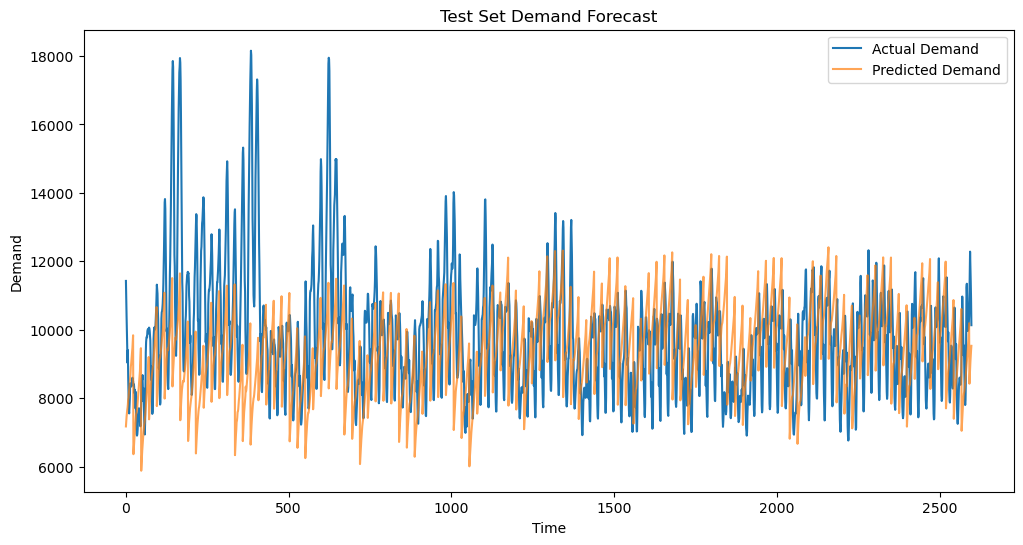

Test Set - MSE: 4525978.8944, MAPE: 0.1542


In [123]:
# Prepare the initial LSTM input (last 168 lags from validation set)
initial_input_lstm = X_lstm_val[-1].unsqueeze(0)  # Taking the last sequence of the validation set

# Perform dynamic forecasting on the test set
predicted_test_values = dynamic_forecast_test_set(model, initial_input_lstm, X_fc_test, y_test)

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual Demand')
plt.plot(predicted_test_values, label='Predicted Demand', alpha=0.7)
plt.title('Test Set Demand Forecast')
plt.xlabel('Time')
plt.ylabel('Demand')
plt.legend()
plt.show()

# Calculate MSE and MAPE
test_mse = mean_squared_error(y_test, predicted_test_values)
test_mape = mean_absolute_percentage_error(y_test, predicted_test_values)
print(f"Test Set - MSE: {test_mse:.4f}, MAPE: {test_mape:.4f}")